In [1]:
import sys
sys.path.append("..")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from util.scrape_log import scrape_search_log
from dataset.goose_domain_info import GOOSE_DOMAINS as DOMAINS
from dataset.goose_domain_info import get_domain_instance_pddl_for_domain

In [2]:
_LOG_DIR = "../aaai24_logs/test"

In [3]:
"/home/dillon/code/goose-aaai24/learner/aaai24_logs/test/blocks15-task01_dd_llg_blocks_L4_H64_max_p10.log"
MODELS = ["dd_llg"]
GOOSE_PARAMS = "L4_H64_max_p10"
DOMAINS = sorted(DOMAINS)

In [4]:
coverage = {k:0 for k in product(MODELS, DOMAINS)}
expanded = {k:[] for k in product(MODELS, DOMAINS)}

for model, domain in product(MODELS, DOMAINS):
    for _, _, pf in get_domain_instance_pddl_for_domain(domain, "test", dir_of_pddls=f"../../dataset/goose/{domain}"):
        problem_name = os.path.basename(pf).replace(".pddl", "")
        log_file = "_".join([problem_name, model, domain, GOOSE_PARAMS])
        log_file = f"{_LOG_DIR}/{log_file}.log"
        stats = scrape_search_log(log_file)
        coverage[(model, domain)] += stats["solved"]
        expanded[(model, domain)].append(stats["expanded"])

### Coverage

In [5]:
data = {"domain": []}
for model in MODELS:
    data[model] = []
for domain in DOMAINS:
    data["domain"].append(domain)
    for model in MODELS:
        data[model].append(coverage[(model, domain)])
df = pd.DataFrame(data=data)
df

,domain,dd_llg
0,blocks,21
1,ferry,81
2,gripper,18
3,n-puzzle,0
4,sokoban,40
5,spanner,60
6,visitall,44
7,visitsome,20


### Expanded

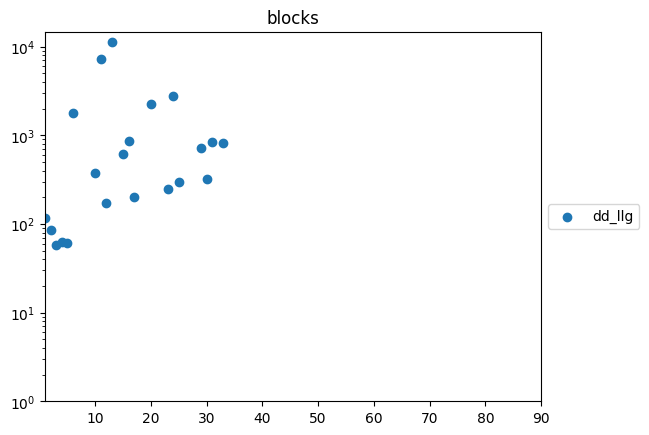

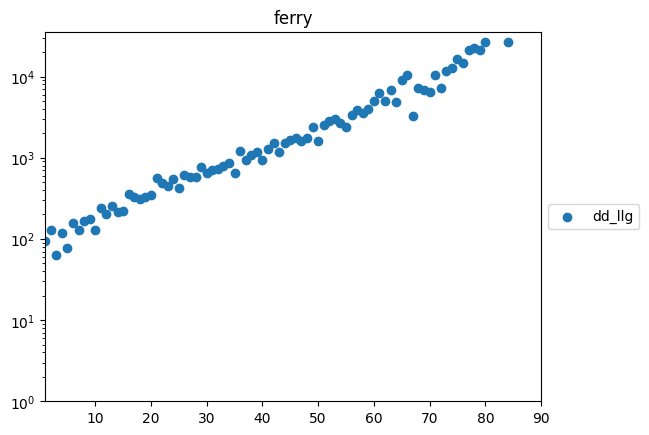

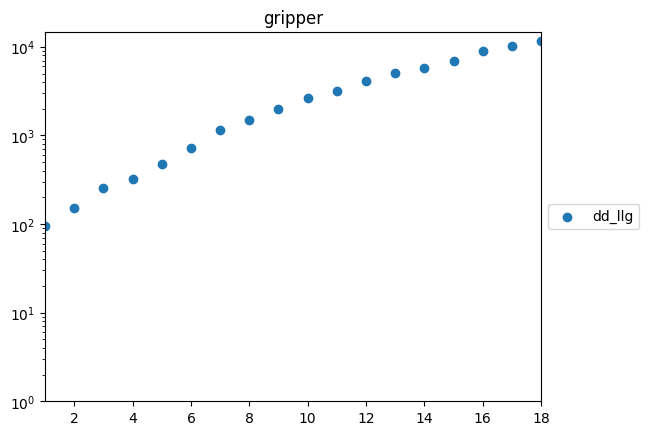

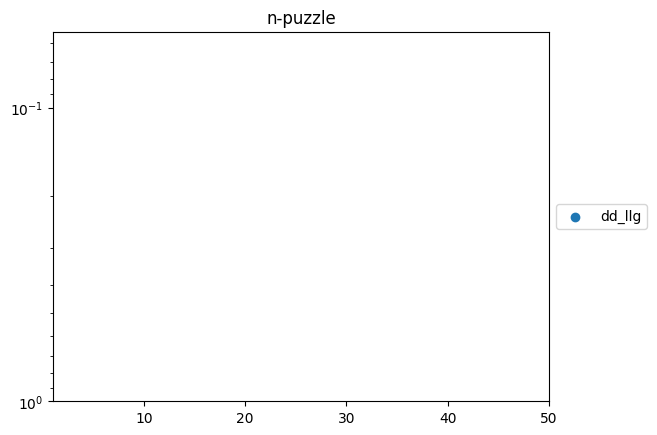

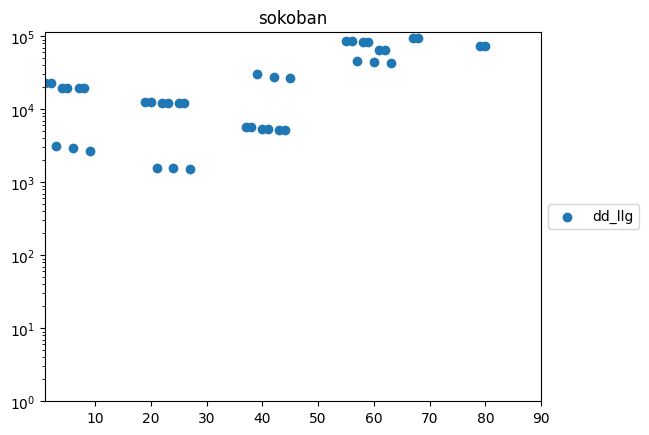

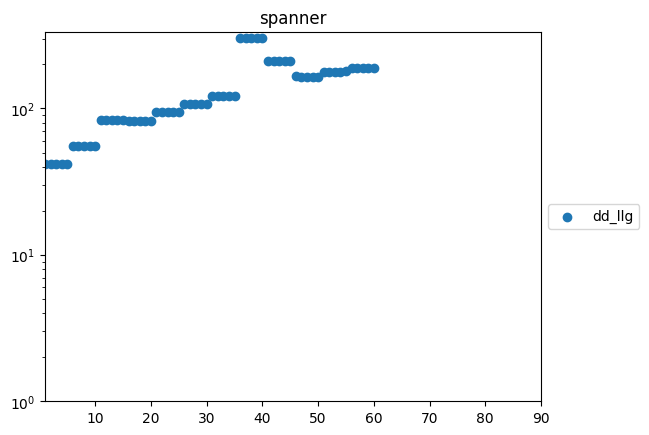

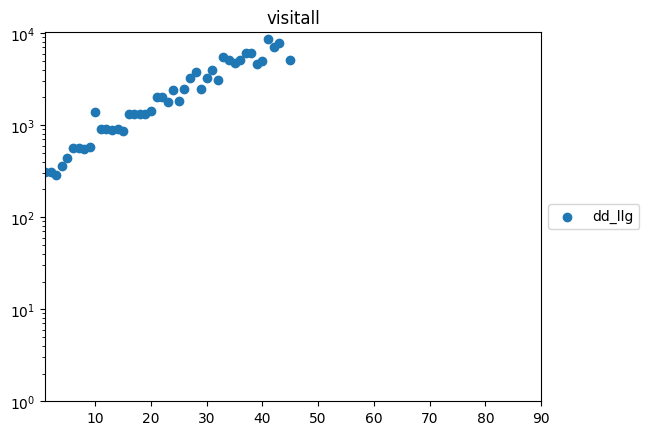

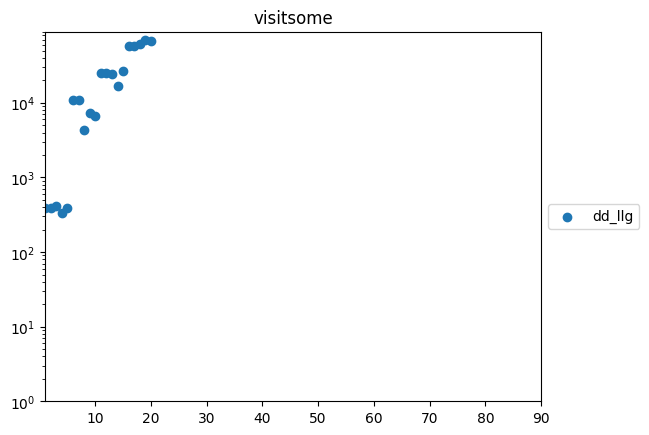

<Figure size 640x480 with 0 Axes>

In [12]:
for domain in DOMAINS:
    for model in MODELS:
        xs, ys = [], []
        expanded_array = expanded[(model, domain)]
        for i, exp in enumerate(expanded_array):
            if exp == -1:
                continue
            xs.append(i+1)
            ys.append(exp)
        plt.scatter(xs, ys, label=model)
    plt.title(domain)
    plt.xlim((1, len(expanded_array)))
    plt.yscale("log")
    plt.ylim(bottom=1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()